Date: 2nd January 2024

### Particle Swarm Optimization <br>
In this notebook, we attempt to implement the Particle Swarm Optimization (PSO) algorithm to solve the anderson SIP.

In [13]:
!pip install pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 26.8 MB/s eta 0:00:00


In [ ]:
import numpy as np

Refer the SA_1_anderson.ipynb file for context.

**Algorithm**: First we shall try to implement a PSO technique.

**Function 1 (Store Constraints)** <br>
Function: Given the constraints which are a part of the problem given, store the coefficients in the form of an array. The dimension of the array which stores the coefficients is $(n,n+1)$ where $n$ is the dimension of the $X$ domain.


In [14]:
def evaluate_t_constraints(dimx, uncertainties):
    dimx_plus_1 = dimx + 1
    constraint_coeff_array = np.zeros((dimx, dimx_plus_1))

    for i in range(dimx):
        constraint_coeff_array[i][0] = -uncertainties[i][0]
        constraint_coeff_array[i][1] = -uncertainties[i][1]
        constraint_coeff_array[i][2] = -1
        constraint_coeff_array[i][3] = -1/6 * ((uncertainties[i][0] - 1)**2 +
                                                uncertainties[i][1]) \
                                        * (uncertainties[i][0] + (2 - uncertainties[i][1]))

    return constraint_coeff_array

In [15]:
# Example usage:
n = 3  # replace with the actual value of dimx
uncertainties_array = np.array([[1, 0], [2, 0], [3, 0]])  # replace with the actual uncertainties array

result_coefficients = evaluate_t_constraints(n, uncertainties_array)
print("Resulting Coefficients Array:")
print(result_coefficients)

Resulting Coefficients Array:
[[-1.          0.         -1.         -0.        ]
 [-2.          0.         -1.         -0.66666667]
 [-3.          0.         -1.         -3.33333333]]


**Function 2 (Convert to PuLP problem)** <br>
Function: Convert the given problem to a PuLP problem. The input passed is the coefficient array which was defined before. The PuLP problem is given as a module which computes the optimal value of the input problem on the basis of the coefficients.

In [16]:
from pulp import LpProblem, LpMinimize, LpVariable, LpStatus, PULP_CBC_CMD

def solve_for_G_of_omega(constraint_coeff_array, dimx, MINIMUM_N=-1e8, MAXIMUM_N=1e8):
    prob = LpProblem("FindG", LpMinimize)
    set_x = range(dimx)

    G_omega = LpVariable.dicts("x", lowBound=MINIMUM_N, upBound=MAXIMUM_N, indices=set_x, cat='Continuous')
    prob += G_omega[2]

    for i in set_x:
        prob += 0 >= G_omega[0] * constraint_coeff_array[i][0] + \
                      G_omega[1] * constraint_coeff_array[i][1] + \
                      G_omega[2] * constraint_coeff_array[i][2] + \
                      constraint_coeff_array[i][3]

    prob.solve(PULP_CBC_CMD())

    # Print solver status
    #print("Solver status:", LpStatus[prob.status])

    G_of_omega = np.array([G_omega[i].varValue for i in set_x])

    return G_of_omega[2]

In [17]:
# Example usage:
dimx = 3  # replace with the actual value of dimx
MINIMUM_N = -1e8  # replace with the actual minimum value
MAXIMUM_N = 1e8 # replace with the actual maximum value

# Assuming you have the constraint_coeff_array
constraint_coeff_array =evaluate_t_constraints(3, np.array([[0, 10e-5       ],\
 [0.88774755  ,0.6832124 ],\
 [1.39025533 ,2.        ]]))
result = solve_for_G_of_omega(constraint_coeff_array, dimx, MINIMUM_N, MAXIMUM_N)
print("Result:", result)

Result: -10000.333


**Function 3 (Initial Point)** <br>
Given an interval $I$ and $n,k$ which are dimensions of an array, generate a numpy array of dimension $n \times k$ and initialize it elementwise with a number randomly chosen from the interval $I$.

In [3]:
import numpy as np

def generate_initial_point(n, k, interval_I):
    """
    Generate an initial point numpy array of dimension n x k with random values from interval I.

    Parameters:
    - n: Number of rows.
    - k: Number of columns.
    - interval_I: Tuple representing the interval (start, end).

    Returns:
    - initial_point: Numpy array of shape (n, k) with random values from interval I.
    """
    start, end = interval_I
    end_inclusive = end + 1e-10  # A small offset to include the endpoint
    initial_point = np.random.uniform(start, end_inclusive, size=(n, k))
    return initial_point

In [ ]:
# Example usage:
interval_I = (0, 2)  # Adjust the interval I as needed
n = 3  # Number of rows
k = 2  # Number of columns

initial_point = generate_initial_point(n, k, interval_I)
print("Initial Point:\n", initial_point)

Initial Point:
 [[0.52341137 0.4939576 ]
 [1.81250916 0.4990924 ]
 [0.54389945 1.51879652]]


**Function 4 (Particle Swarm Optimization)** <br>
Function: The method in which the PSO algorithm will work is as follows: <br>
1. The optimization routine will run for a given number of iterations (say, $T$ = 100) <br>
2. The total number of particles in our swarm will be fixed, let us call this number $P$, for population <br>
3. At each iteration, each of the particles shall occupy one of the locations in the $U$-space, i.e. the domain $U^n$. Thus, associated with each particle $i$, there is a matrix $U_i$ and the particle can obtain the fitness function for that $U_i$, given by $f(U_i)$. <br>
4. Along with the location, there is also a velocity term $\Delta U_i$, which decides the new position of the particle at the end of the iteration. This is again a matrix. <br>
5. The initial locations and velocities have to be defined through some initialization procedure. One could use methods such as blue noise, white noise sampling, which allow for a good distribution. One could also see whether PSO methods are susceptible to minor changes in the initial conditions. <br>
6. Once $f(U_i)$ is computed for all $i$, we find out the position of the best particle and the best value achieved through the algorithm <br>
7. Once that is done, the state and velocity matrices are updated according to the update rule, which has three hyperparameters: $I_v$, the inertia weight, $S_d$, the social displacement component and $C_d$, the cognitive displacement component. <br>
8. Once can also choose some norm during the update for considering the terms to be used. <br>
9. Further, the algorithm should also track the personal best and global best values throughout the run of the algorithm <br>
10. Since runtime of the algorithm is a good metric to be used, we also want the algorithm to compute the runtime.

**Function 4.1 (Initialization)** <br>

In [27]:
import numpy as np

def initialize_particles(num_particles, n, k, interval_I):
    """
    Initialize particle positions and velocities.

    Parameters:
    - num_particles: Number of particles in the swarm.
    - num_dimensions: Number of dimensions in the search space.
    - interval_I: Tuple representing the interval (start, end) for random initialization.

    Returns:
    - positions: List of numpy arrays, each of shape (num_dimensions,) representing particle positions.
    - velocities: List of numpy arrays, each of shape (num_dimensions,) representing particle velocities.
    """
    positions = [generate_initial_point(n, k, interval_I) for _ in range(num_particles)]
    velocities = [generate_initial_point(n, k, interval_I) for _ in range(num_particles)]
    return positions, velocities

In [29]:
# Example usage:
num_particles_example = 10
n = 3
k = 2
interval_I_example = (0, 2)

initial_positions, initial_velocities = initialize_particles(num_particles_example, n, k, interval_I_example)

**Function 4.2 (Fitness Computation)** <br>

In [18]:
def evaluate_fitness(positions, n):
    """
    Evaluate the fitness function for each particle.

    Parameters:
    - positions: List of numpy arrays, each of shape (num_dimensions,) representing particle positions.
    - n: Number of rows.

    Returns:
    - fitness_values: List of fitness values corresponding to each particle.
    """
    fitness_values = [solve_for_G_of_omega(evaluate_t_constraints(n, position), n) for position in positions]
    return fitness_values

In [35]:
# Example usage:
num_particles = 100
n = 3
k = 2
interval_I = (0, 2)

# Initialize particles
positions, velocities = initialize_particles(num_particles, n, k, interval_I)

# Evaluate fitness values
fitness_values = evaluate_fitness(positions, n)

# Print the results
for i, (position, fitness) in enumerate(zip(positions, fitness_values), 1):
    print(f"Particle {i} - Position: {position}, Fitness: {fitness}")

Particle 1 - Position: [[1.23825145 0.50626077]
 [1.66557499 0.35501486]
 [1.1731683  0.33472713]], Fitness: -100000000.0
Particle 2 - Position: [[0.76606977 1.66135359]
 [0.19052181 1.64838631]
 [0.11242439 1.70445351]], Fitness: -100000000.0
Particle 3 - Position: [[1.5644661  0.50628751]
 [1.03794479 0.13885992]
 [1.26727598 1.34529431]], Fitness: -100000000.0
Particle 4 - Position: [[1.58184451 0.99292516]
 [0.07327437 1.07442342]
 [1.52426664 1.81780183]], Fitness: -100000000.0
Particle 5 - Position: [[1.70334142e+00 5.53740501e-01]
 [9.48300230e-01 1.51634014e-03]
 [7.96624143e-01 7.39891076e-01]], Fitness: -94981657.0
Particle 6 - Position: [[1.48156643 0.57786107]
 [1.7087461  0.86631182]
 [1.80525238 1.99862739]], Fitness: -100000000.0
Particle 7 - Position: [[1.44933592 1.75730005]
 [1.63013524 1.96963352]
 [0.36416204 0.8964874 ]], Fitness: -100000000.0
Particle 8 - Position: [[1.73975995 1.27914985]
 [0.07952837 0.42577658]
 [0.02173086 1.57718096]], Fitness: -50530495.0
Pa

**Function 4.3 (Retention)** <br>

In [37]:
def update_best_fitness(current_best, fitness_values):
    """

    Parameters:
    - current_best: List of the current best fitness values.
    - fitness_values: List of the new fitness values.


    Returns:
    - updated_best: List of updated best fitness values.
    """
    # Update best fitness
    current_best = max(current_best, fitness_values)
    return current_best

In [38]:
print(update_best_fitness(fitness_values, fitness_values))

[-100000000.0, -100000000.0, -100000000.0, -100000000.0, -94981657.0, -100000000.0, -100000000.0, -50530495.0, -100000000.0, -100000000.0, -100000000.0, -100000000.0, -87610501.0, -100000000.0, -100000000.0, -100000000.0, -39875029.0, -83588480.0, -100000000.0, -100000000.0, -100000000.0, -50302626.0, -100000000.0, -57889873.0, -100000000.0, -100000000.0, -100000000.0, -100000000.0, -25958824.0, -100000000.0, -8557366.4, -100000000.0, -83455054.0, -100000000.0, -100000000.0, -100000000.0, -100000000.0, -100000000.0, -65479688.0, -100000000.0, -71448277.0, -100000000.0, -100000000.0, -100000000.0, -84008538.0, -100000000.0, -100000000.0, -100000000.0, -100000000.0, -46812824.0, -100000000.0, -100000000.0, -100000000.0, -41909854.0, -100000000.0, -74763377.0, -100000000.0, -100000000.0, -100000000.0, -31315960.0, -100000000.0, -100000000.0, -100000000.0, -100000000.0, -100000000.0, -81159197.0, -39897733.0, -100000000.0, -100000000.0, -100000000.0, -88441913.0, -61106575.0, -97533329.0, 

In [56]:
def update_best_positions(positions, fitness_values, current_best_positions, current_best, n_particles):
    """
    Update the best position at a specific index based on the current positions and fitness values.

    Parameters:
    - current_best_positions: List of the current best positions.
    - positions: List of the new positions.
    - fitness_values: List of the fitness values corresponding to the positions.
    - index: Index at which to update the best position.

    Returns:
    - updated_best_positions: List of updated best positions.
    """
    for index in range(0, n_particles):
      if fitness_values[index] > current_best[index]:
          current_best_positions[index] = positions[index]
    return current_best_positions


In [ ]:
print(update_best_positions(positions, positions, fitness_values, fitness_values, 100))

In [43]:
def find_global_best_position(current_global_best, current_global_best_value, positions, fitness_values):
    """
    Find the global best position based on the fitness values.

    Parameters:
    - current_global_best: Current global best position.
    - current_global_best_value: Current global best fitness value.
    - positions: List of particle positions.
    - fitness_values: List of fitness values corresponding to the positions.

    Returns:
    - updated_global_best_position: Updated global best position.
    - updated_global_best_value: Updated global best fitness value.
    """
    max_fitness = max(fitness_values)

    if max_fitness > current_global_best_value:
        max_index = fitness_values.index(max_fitness)
        updated_global_best_position = positions[max_index]
        updated_global_best_value = max_fitness
    else:
        updated_global_best_position = current_global_best
        updated_global_best_value = current_global_best_value

    return updated_global_best_position, updated_global_best_value


**Function 4.4 (Velocity Update)**

In [79]:
import numpy as np

def update_particles(positions, velocities, global_best, personal_best, inertia_weight, social_weight, cognitive_weight, interval_I):
    """
    Update particle velocities.

    Parameters:
    - positions: List of numpy arrays, each of shape (num_dimensions,) representing particle positions.
    - velocities: List of numpy arrays, each of shape (num_dimensions,) representing particle velocities.
    - global_best: Global best position.
    - personal_best: List of personal best positions for each particle.
    - inertia_weight: Inertia weight parameter.
    - social_weight: Social weight parameter.
    - cognitive_weight: Cognitive weight parameter.
    - interval_I: Tuple representing the interval (start, end) for random initialization.

    Returns:
    - updated_velocities: List of updated particle velocities.
    """
    num_particles = len(positions)
    num_dimensions = len(positions[0])

    updated_velocities = []
    updated_positions = []

    for i in range(num_particles):
        # Inertia term
        inertia_term = inertia_weight * velocities[i]

        # Social term
        social_term = social_weight * np.random.rand() * (global_best - positions[i])

        # Cognitive term
        cognitive_term = cognitive_weight * np.random.rand() * (personal_best[i] - positions[i])

        # Update velocity for the current particle
        updated_velocity = inertia_term + social_term + cognitive_term

        # Clip velocity to the interval
        velocity_magnitude = np.linalg.norm(updated_velocity)
        max_velocity_magnitude = interval_I[1] - interval_I[0]
        normalized_velocity = (updated_velocity / velocity_magnitude) * max_velocity_magnitude
        updated_velocity = np.clip(normalized_velocity, -max_velocity_magnitude, max_velocity_magnitude)

        updated_position = np.clip(positions[i] + updated_velocity, interval_I[0], interval_I[1])
        updated_velocities.append(updated_velocity)
        updated_positions.append(updated_position)
    return updated_positions, updated_velocities


**Function 4.5 (PSO Loop)** <br>

In [81]:
import numpy as np

def particle_swarm_optimization(tau, num_particles, n, k, interval_I, inertia_weight=0.5, social_weight=1.5, cognitive_weight=1.5):
    """
    Particle Swarm Optimization algorithm.

    Parameters:
    - tau: Number of iterations.
    - num_particles: Number of particles in the swarm.
    - n: Number of rows.
    - k: Number of columns.
    - interval_I: Tuple representing the interval (start, end).
    - inertia_weight: Inertia weight parameter.
    - social_weight: Social weight parameter.
    - cognitive_weight: Cognitive weight parameter.

    Returns:
    - optimal_points: List of best points found during the iterations.
    - optimal_values: List of corresponding maximum values of G.
    """
    # Initialization
    positions, velocities = initialize_particles(num_particles, n, k, interval_I)
    fitness_values = evaluate_fitness(positions, n)
    personal_best = positions.copy()
    personal_best_values = fitness_values.copy()
    global_best_index = fitness_values.index(max(fitness_values))
    global_best = positions[global_best_index]
    global_best_value = max(fitness_values)

    optimal_points = [global_best]
    optimal_values = [fitness_values[global_best_index]]

    N = 1  # Iteration counter

    while N < tau:
        # Update particle positions and velocities
        positions, velocities = update_particles(positions, velocities, global_best, personal_best, inertia_weight, social_weight, cognitive_weight, interval_I)

        # Evaluate fitness for the new positions
        fitness_values = evaluate_fitness(positions, n)

        personal_best_values = update_best_fitness(personal_best_values, fitness_values)
        personal_best  = update_best_positions(positions, fitness_values, personal_best, personal_best_values, num_particles)
        # Update global best
        global_best, global_best_value = find_global_best_position(global_best, global_best_value, positions, fitness_values)

        # Update optimal value
        optimal_points.append(global_best)
        optimal_values.append(global_best_value)

        # Update iteration counter
        N += 1

    return optimal_points, optimal_values


In [82]:
# Example usage
tau_pso = 5
num_particles_pso = 20
n_pso = 3
k_pso = 2
interval_I_pso = (0, 2)

optimal_points_pso, optimal_values_pso = particle_swarm_optimization(tau_pso, num_particles_pso, n_pso, k_pso, interval_I_pso)

# You can use optimal_points_pso and optimal_values_pso for plotting and analysis

In [83]:
print(optimal_values_pso)

[-23841517.0, -23841517.0, -0.33333333, -0.33333333, -0.33333333]


In [84]:
print(optimal_points_pso)

[array([[1.7736696 , 0.31474619],
       [0.59601083, 1.82988836],
       [0.06881091, 0.16960426]]), array([[1.7736696 , 0.31474619],
       [0.59601083, 1.82988836],
       [0.06881091, 0.16960426]]), array([[1.7914747 , 0.        ],
       [0.12406443, 2.        ],
       [0.        , 0.        ]]), array([[1.7914747 , 0.        ],
       [0.12406443, 2.        ],
       [0.        , 0.        ]]), array([[1.7914747 , 0.        ],
       [0.12406443, 2.        ],
       [0.        , 0.        ]])]


**Function 10 (Optimal Value Graph)** <br>
Function: Plot the optimal value achieved by the algorithm against the number of iterations

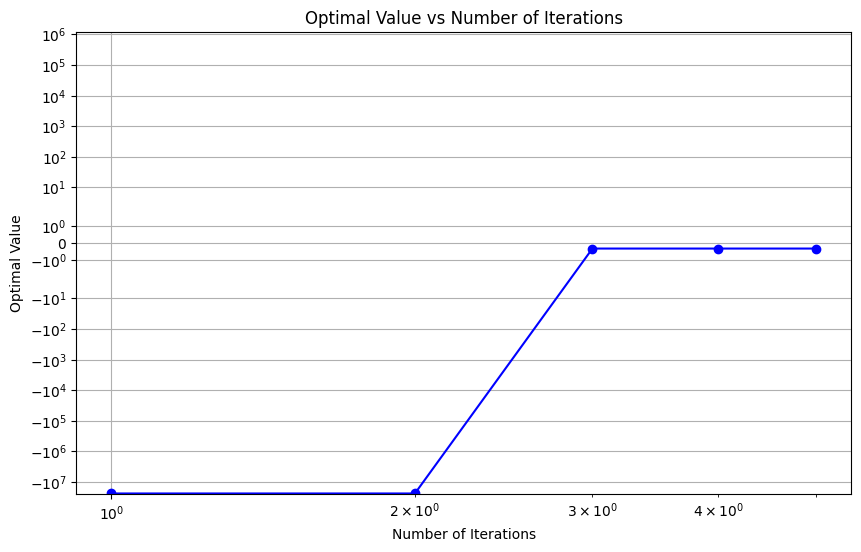

In [85]:
import matplotlib.pyplot as plt

def plot_optimal_values(optimal_values, log_scale=False):
    """
    Plot the graph of optimal values against the number of iterations.

    Parameters:
    - optimal_values: List of optimal values.
    - log_scale: Boolean, whether to use a logarithmic scale for the x-axis.
    """
    iterations = range(1, len(optimal_values) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(iterations, optimal_values, marker='o', linestyle='-', color='b')
    plt.title('Optimal Value vs Number of Iterations')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Optimal Value')

    if log_scale:
        plt.xscale('log')
        plt.yscale('symlog')

    plt.grid(True)
    plt.show()

# Example usage:
plot_optimal_values(optimal_values_pso, log_scale=True)


**Function 11 (Visualize $U^n$)** <br>
Code to visualize how the points travelled by the algorithm change over the course of the iterations.

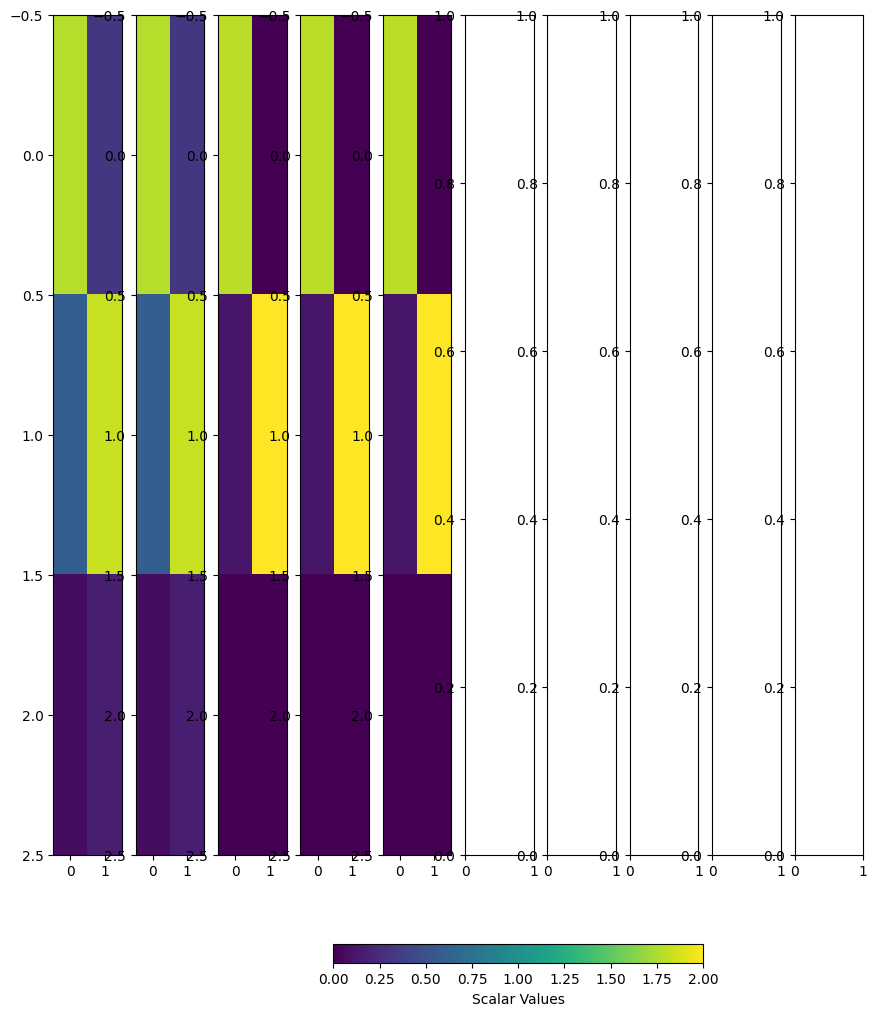

In [91]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Set up the layout of subplots
num_rows = int(len(optimal_points_pso)/10)+ 1
num_cols = 10
u_points = optimal_points_pso

# Create a figure and axis
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot each 2x3 array in u_points up to the number of available subplots
cmap = 'viridis'
vmin, vmax = np.min(u_points), np.max(u_points)

for i, array in enumerate(u_points[:len(axes)]):
    ax = axes[i]
    im = ax.imshow(array, cmap=cmap, interpolation='none', aspect='auto', vmin=vmin, vmax=vmax)
    #ax.set_title(f"Array {i+1}")

# Create a ScalarMappable
norm = Normalize(vmin=vmin, vmax=vmax)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # This line is necessary for the ScalarMappable to work

# Create a colorbar
cbar = plt.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.02, pad=0.1)
cbar.set_label('Scalar Values')

# Adjust layout using subplots_adjust
plt.subplots_adjust(bottom=0.2, right=0.8, top=0.9)

# Show the plot
plt.show()

